In [82]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, RandomSurvivalForest
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
import numpy as np
import pandas as pd
import random
def compare_models(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    

    # Initialize the GBST survival regressor
    gbst = GradientBoostingSurvivalAnalysis(n_estimators=100, random_state=20)
    # Fit the model to the training data
    gbst.fit(X_train, y_train)
    # Predict the survival times for the testing data
    survival_times_gbst = gbst.predict(X_test)

    # Create an instance of the RandomSurvivalForest model
    rsf = RandomSurvivalForest(n_estimators=100, random_state=20)
    # Fit the model on the training data
    rsf.fit(X_train, y_train)
    # Predict the survival times for the testing data
    survival_times_rsf = rsf.predict(X_test)

    # Prepare the target variable for CoxPHSurvivalAnalysis
    y_coxph = np.array(list(zip(y_train['event'], y_train['time'])), dtype=[('event', bool), ('time', float)])

    # Create an instance of the CoxPHSurvivalAnalysis model with regularization
    coxph = CoxPHSurvivalAnalysis(alpha=1e-9)
    # Fit the model on the training data
    coxph.fit(X_train, y_coxph)
    # Predict the survival times for the testing data
    survival_times_coxph = coxph.predict(X_test)

    # Compute the concordance index to evaluate the model performance
    c_index_gradient = concordance_index(y_test['time'], -survival_times_gbst, y_test['event'])
    c_index_rf = concordance_index(y_test['time'], -survival_times_rsf, y_test['event'])
    c_index_coxph = concordance_index(y_test['time'], -survival_times_coxph, y_test['event'])

    return {
        "gradient": c_index_gradient,
        "random_survival": c_index_rf,
        "coxph": c_index_coxph,
        'coxfitter': c_index_mean
}


In [83]:

data = pd.read_csv('IFR_Extract_with_selected_columns_15-5-23.csv')

obreak_date = pd.to_datetime(data.obreak_date)
datebone = pd.to_datetime(data.datebone)
y = ( abs( datebone - obreak_date))
X = data.drop(["obreak_date","datebone"],axis=1)
selectedColumns = [ 'PatientAge', "PatientGender",'parentbreak', 'alcohol',
                'arthritis', 'diabetes',
                'oralster', 'smoke', 'obreak']
dropList = []
for i in data:
    if data[i].dtypes == 'O':
        dropList.append(data[i].name)
dropList.append("CompletedSurveyId")
dropList.append("PatientId")
X = data.drop(dropList,axis=1)
X.fillna(0,inplace=True)
y = pd.DataFrame({"time":y})

y['event'] = y.time.apply(lambda x: x.days != 0 )
structured_array = y.to_records(index=False)

swapped = pd.DataFrame({
    "event": y.event,
    "time": y.time.apply(lambda x: x.days)
})
(swapped.event).value_counts()
swapped.event = swapped.event.astype(bool)
structured_array = np.rec.array(swapped.to_records(index=False))

mergedBeforeEncoding = pd.concat([X[selectedColumns],swapped],axis=1)
mergedBeforeEncoding

,PatientAge,PatientGender,parentbreak,alcohol,arthritis,diabetes,oralster,smoke,obreak,event,time
0,53,1,0,0,0.0,0.0,0,0,1,True,524
1,85,1,0,0,0.0,1.0,0,0,1,True,2046
2,90,1,0,0,1.0,0.0,0,0,1,True,15455
3,81,1,0,0,0.0,0.0,0,0,1,True,4354
4,60,1,1,0,0.0,1.0,0,0,1,True,2207
...,...,...,...,...,...,...,...,...,...,...,...
795,83,1,4,0,0.0,0.0,4,0,1,True,579
796,60,1,0,0,0.0,0.0,0,0,1,True,5109
797,76,2,0,0,0.0,0.0,0,0,1,True,2125
798,61,1,2,1,0.0,0.0,0,1,1,True,518


In [84]:
import random
# Define the number of synthetic samples
num_samples = 0

# Get the column types for each column in mergedBeforeEncoding
column_types = {}
for column in mergedBeforeEncoding.columns:
    column_types[column] = mergedBeforeEncoding[column].dtype

# Shuffle the feature names
feature_names = list(mergedBeforeEncoding.columns)
random.shuffle(feature_names)

# Initialize an empty DataFrame to store the selected features and their performance
selected_features = pd.DataFrame(columns=["Feature"])

# Create a synthetic data DataFrame with the same columns as mergedBeforeEncoding
synthetic_data = pd.DataFrame(columns=mergedBeforeEncoding.columns)

# Generate synthetic data for each feature
for feature in feature_names:
    column_type = column_types[feature]

    if column_type == bool:
        synthetic_data[feature] = np.random.choice([False, True], size=num_samples)
    else:
        # Sample values from the existing data to maintain the distribution
        existing_data_values = mergedBeforeEncoding[feature].dropna().values
        synthetic_data[feature] = np.random.choice(existing_data_values, size=num_samples)

    synthetic_data[feature] = synthetic_data[feature].astype(column_type)

# Add additional columns to the synthetic data
synthetic_data["obreak"] = 1
synthetic_data["event"] = False
synthetic_data["time"] = 0

augmented_data = pd.concat([mergedBeforeEncoding, synthetic_data], ignore_index=True)



# Store the selected features
selected_features["Feature"] = feature_names

cat_features = ['parentbreak', 'alcohol',
                'oralster', 'smoke'
                # These features were determined to apply minimal impact even
                # 'respdisease', 'hbp','heartdisease',
                # 'ptunsteady', 'wasfractdue2fall', 'cholesterol',
                # 'ptfall', 'shoulder', 'wrist', 'bmdtest_10yr_caroc'
                ]

for feature in cat_features:
    if augmented_data is not None:
        if feature in augmented_data.columns:
            cat_one_hot = pd.get_dummies(augmented_data[feature], prefix=f'{feature}', drop_first=False)
            augmented_data = augmented_data.drop(feature, axis=1)
            augmented_data = augmented_data.join(cat_one_hot)
            
X = augmented_data.drop(['event','time'],axis=1)
y = augmented_data[['event','time']]

y = np.rec.array(y.to_records(index=False))

In [85]:
import itertools
feature_comparisons = {
    'gradient':'',
    'random_survival':'',
    'coxph':''
    
}
def explore_feature_combinations(X, y, max_iterations=1000):
    best_features = []
    best_performance = 0
    best_model_name = ""

    current_features = set()
    remaining_features = set(X.columns)

    while remaining_features:
        performance_gain = False
        best_gain = 0
        best_feature = None

        for feature in remaining_features:
            features_to_try = current_features | {feature}
            X_subset = X[list(features_to_try)]
            outcome = compare_models(X_subset, y)

            if outcome['gradient'] > best_performance:
                gain = outcome['gradient'] - best_performance
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_model_name = 'gradient'
                    feature_comparisons['gradient'] = outcome['gradient']
                    feature_comparisons['random_survival'] = outcome['random_survival']
                    feature_comparisons['coxph'] = outcome['coxph']

            if outcome['random_survival'] > best_performance:
                gain = outcome['random_survival'] - best_performance
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_model_name = 'random_survival'
                    feature_comparisons['gradient'] = outcome['gradient']
                    feature_comparisons['random_survival'] = outcome['random_survival']
                    feature_comparisons['coxph'] = outcome['coxph']

            if outcome['coxph'] > best_performance:
                gain = outcome['coxph'] - best_performance
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_model_name = 'coxph'
                    feature_comparisons['gradient'] = outcome['gradient']
                    feature_comparisons['random_survival'] = outcome['random_survival']
                    feature_comparisons['coxph'] = outcome['coxph']
            
        if best_feature is not None:
            current_features.add(best_feature)
            remaining_features.remove(best_feature)
            best_performance += best_gain
            performance_gain = True

        if not performance_gain or len(current_features) >= max_iterations:
            break

    return best_model_name, list(current_features), best_performance

# Call the function with a maximum of iterations equal to the total number of features
best_model_name, best_features, best_performance = explore_feature_combinations(X, y, max_iterations=len(X.columns))

print("Best feature combination:", best_features)
print("Highest C-index:", best_performance)
print("Best Model:", best_model_name)
for key,(i,j) in enumerate(feature_comparisons.items()):
    print(i,j)

Best feature combination: ['parentbreak_1', 'parentbreak_0', 'oralster_2', 'arthritis', 'oralster_0', 'smoke_1']
Highest C-index: 0.5519864066672061
Best Model: coxph
gradient 0.5439355934946193
random_survival 0.5441783315802249
coxph 0.5519864066672061


In [86]:
from lifelines import CoxPHFitter

selected_data = pd.concat([X,pd.DataFrame(y)],axis=1)
best_features

['parentbreak_1',
 'parentbreak_0',
 'oralster_2',
 'arthritis',
 'oralster_0',
 'smoke_1']

Cross-validated C-index: 0.544


<Axes: xlabel='log(HR) (95% CI)'>

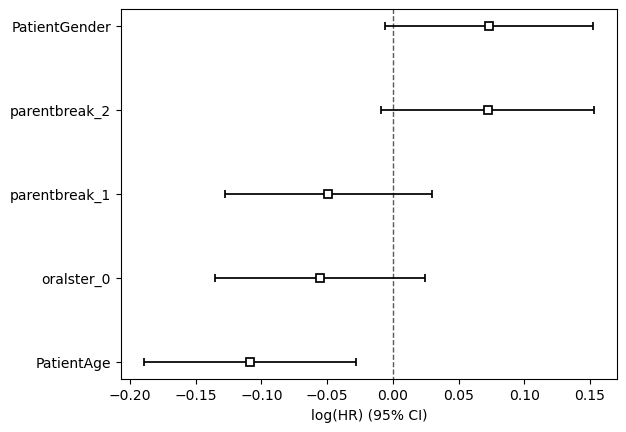

In [100]:
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform LASSO feature selection
lasso = LassoCV(cv=5)
lasso.fit(X_scaled, y['time'])
selected_features = lasso.coef_ != 0

# Filter the selected feature names
feature_names = X.columns[selected_features].tolist()

# Create a DataFrame with selected features
selected_data = pd.DataFrame(X_scaled[:, selected_features], columns=feature_names)
selected_data['event'] = y['event']
selected_data['time'] = y['time']

# Drop columns with low variance
selected_data = selected_data.drop(['smoke_3'], axis=1)

# Fit CoxPH model on the selected features
cph = CoxPHFitter()
cph.fit(selected_data, duration_col='time', event_col='event')

# Assess model performance using cross-validation
c_index_values = k_fold_cross_validation(cph, selected_data, duration_col='time', event_col='event', k=5, scoring_method='concordance_index')
c_index_mean = np.mean(c_index_values)
print("Cross-validated C-index: {:.3f}".format(c_index_mean))
# Get the first feature name as the covariate
covariate = feature_names[0]

# Plot the partial effects for all features
cph.plot()


In [91]:
from sksurv.nonparametric import kaplan_meier_estimator
from lifelines.utils import concordance_index

# Fit the Kaplan-Meier estimator
time, survival_probs = kaplan_meier_estimator(y['event'], y['time'])

# Get the survival probabilities for each individual data point
individual_survival_probs = survival_probs[np.searchsorted(time, y['time'])]

# Calculate the c-index
c_index = concordance_index(y['time'], -individual_survival_probs, y['event'])
print("Concordance Index:", c_index)
print(survival_probs)


Concordance Index: 1.0
[1.         0.99873737 0.99747475 0.99621212 0.99494949 0.99368687
 0.98989899 0.98863636 0.98737374 0.98358586 0.98232323 0.98106061
 0.97979798 0.97853535 0.97727273 0.9760101  0.97474747 0.97222222
 0.9709596  0.96843434 0.96717172 0.96590909 0.96464646 0.96338384
 0.96212121 0.96085859 0.95833333 0.95707071 0.95580808 0.95328283
 0.94949495 0.94823232 0.94570707 0.94444444 0.94318182 0.94191919
 0.94065657 0.93939394 0.93813131 0.93686869 0.93560606 0.93308081
 0.93181818 0.93055556 0.92929293 0.92676768 0.92550505 0.92424242
 0.9229798  0.92171717 0.92045455 0.91919192 0.91792929 0.91666667
 0.91540404 0.91414141 0.91287879 0.91161616 0.91035354 0.90909091
 0.90656566 0.90530303 0.9040404  0.90277778 0.90025253 0.8989899
 0.89772727 0.89646465 0.89520202 0.89393939 0.89267677 0.89141414
 0.89015152 0.88762626 0.88636364 0.88510101 0.88005051 0.87878788
 0.87752525 0.87626263 0.875      0.87247475 0.87121212 0.86868687
 0.86742424 0.86489899 0.86363636 0.8623

ValueError: The number of covariates must equal to second dimension of the values array.